# Raw data importing
Our primary goal here is to import, interpolate, and extend our bike riding GPS data. It'll be somewhat complicated as it is not small task on code, but using vectorization on all processes will keep execution really fast. We have for this task about 1.7M datapoints. Each datapoint corresponds to a fancy **one point in space time**, i.e. one point made of 4 dimensions of timestamp, latitude, longitude and elevation. We hope that connection each one sequentially on time will render a path that a biker rode. To guarantee bookeeping and post processing capabilities, we will record the point id, ride id and rider id.

In [2]:
# import needed packages
import gpxpy
import datetime 
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import numpy as np
import re
import sys
import pandas as pd
import pickle as pk
from tqdm import tqdm_notebook as tqdm
from geopy.distance import great_circle
# from scipy.signal import gaussian
# from scipy.ndimage import filters
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nvector as nv
from pandas.plotting import andrews_curves

In [3]:
# import the gpx data
gpx_filename_pattern = re.compile("(gpx)$")
def build_meta(gpx): 
    meta = {
        "tracks": 0,
        "segments": 0,
        "points": 0
    }
    for track in gpx.tracks:
        meta["tracks"] += 1
        for segment in track.segments:
            meta["segments"] += 1
            for point in segment.points:
                meta["points"] += 1
    return meta

def import_gpx_file(path, filename):
    build_meta
    file = open(path+'/'+filename, 'r')
    gpx = gpxpy.parse(file)
    meta = build_meta(gpx)
    data = np.zeros((meta['points'], 5))
    n = 0
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                t = time.mktime(point.time.timetuple())
                data[n, ] = [point.latitude, point.longitude, point.elevation, t, n]
                n += 1
    return pd.DataFrame({
        'latitude': data[:,0],
        'longitude': data[:,1],
        'elevation': data[:,2],
        'timestamp': data[:,3],
        'point': data[:,4],
        'ride': 0,
        'rider': ""
    })

def import_gpx_dir(path):
    filenames = [f for f in os.listdir(path) if gpx_filename_pattern.search(f)]    
    data = pd.DataFrame()
    n = 0
    for filename in tqdm(filenames, total=len(filenames)):
        dt = import_gpx_file(path, filename)
        dt['ride'] = n
        n += 1
        data = data.append(dt, ignore_index=True)
    return data

def interpret_gpx(path, name):
    data = import_gpx_dir(path)
    data["rider"] = name
    data.elevation = data.elevation.astype(int)
    data.timestamp = data.timestamp.astype(int)
    data.point = data.point.astype(int)
    #save to cache
    cache = open(str(name)+'.pkl', 'wb')
    pk.dump(data, cache)
    cache.close()
    return data

def load_gpx(path):
    cache = open(path, 'rb')
    data = pk.load(cache)
    cache.close()
    return data

def save_data(data, name):
    cache = open(name+".pkl", 'wb')
    pk.dump(data, cache)
    cache.close()
    
def load_data(name):
    cache = open(name+".pkl", 'rb')
    data = pk.load(cache)
    cache.close()
    return data

if(os.path.exists("0.pkl")):
    data1 = load_gpx("0.pkl")
    data2 = load_gpx("1.pkl")
else:
    data1 = interpret_gpx("/Users/esse/activ/rodrigo_sztelzer", 0)
    data2 = interpret_gpx("/Users/esse/activ/marcos_paulo", 1)

imported = data1.append(data2, ignore_index=True)
print(imported.shape)

(1739684, 7)


# Data preprocessing
There will have some steps to have a gooda data shaped to most processes. The idea is to cleanup dirt distances introduced by bad GPS and interpolate the points as to make all rows 1 meter of distance, that will simplify most phisical calculations.

####  Create destination columns
This will transform the list in a origin/destination list of points, so the resulting list is [M-1, N*2]. These new columns are equal to the next row. Finally remove the last element of each ride that has value zero.

In [4]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    return 6372800 * 2 * np.arcsin(np.sqrt(a))

def destiny(dt):
    # create a column with the next points
    dt = dt.sort_values(['timestamp'])
    dt['duration'] = np.roll(dt.timestamp, -1) - dt['timestamp']
    dt.drop(dt.tail(1).index, inplace=True) 

    #repeat the data, set repeats to nan, interpolate nans.
    dt = dt.loc[dt.index.repeat(dt.duration)]   # repeat rows n times based on n duration
    dt['subindex'] = dt.groupby(level=0).cumcount() # creat an intern index of the repeats
    dt[dt.subindex > 0] = np.nan
    dt = dt.interpolate()                           # interpolate the nans
    dt = dt.reset_index()
    del(dt['index'])
    del(dt['duration'])
    del(dt['subindex'])

    dt['ilon'] = dt['longitude']
    dt['ilat'] = dt['latitude']
    dt['ielev'] = dt['elevation']
    dt['itime'] = dt['timestamp']
    dt['flon'] = np.roll(dt.longitude, -1)
    dt['flat'] = np.roll(dt.latitude, -1)
    dt['felev'] = np.roll(dt.elevation, -1)    
    dt['ftime'] = np.roll(dt.timestamp, -1)
    
    del(dt['longitude'])
    del(dt['latitude'])
    del(dt['timestamp'])
    del(dt['elevation'])

    dt['dist'] = haversine(dt.ilon, dt.ilat, dt.flon, dt.flat)

    dt = dt[dt.dist > 0]
    dt = dt[dt.dist < 1000]


    
    dt['heading'] = np.arctan2(dt.flon-dt.ilon, dt.flat-dt.ilat) * 180 / np.pi
    dt['ddist'] = np.roll(dt.dist, -1, 0) - dt.dist
    dt.loc[dt.point==0, 'ddist'] = dt.dist
    dt['delev'] = dt.felev - dt.ielev
    dt['delev'] = np.clip(dt.delev, -1, 1)
    dt['climb'] = dt.delev / dt.dist
    dt['climb'] = dt['climb'].fillna(0)
    
    dt.drop(dt.tail(1).index, inplace=True) 
    
    return dt

In [5]:
data = imported.groupby(['rider', 'ride'], as_index=True, sort=False).apply(destiny)

In [6]:
save_data(data, "grouped")

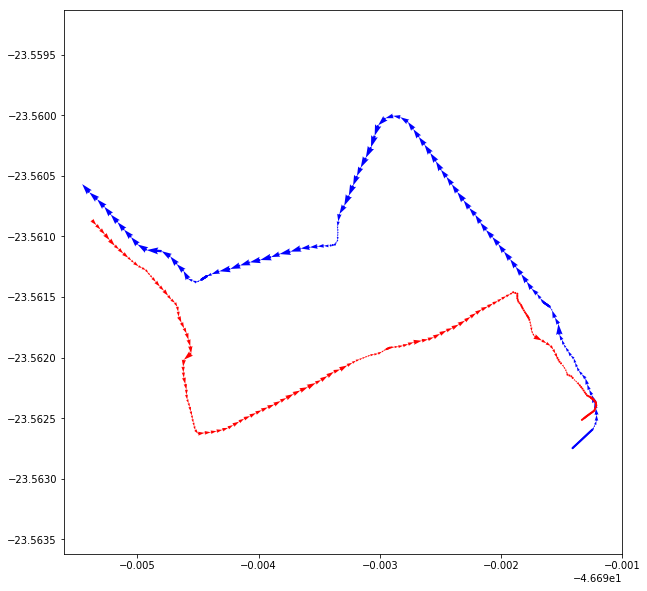

In [7]:
ride = 0
head = data.loc[0].loc[ride].head(210)
tail = data.loc[0].loc[ride].tail(220)

plt.figure(figsize=(10,10))
plt.quiver(head.ilon, head.ilat, head.flon-head.ilon, head.flat-head.ilat, color="blue", units='xy', angles='xy', scale=1, pivot='tail')
plt.quiver(tail.ilon, tail.ilat, tail.flon-tail.ilon, tail.flat-tail.ilat, color="red", units='xy', angles='xy', scale=1, pivot='tail')
plt.axis('equal')
plt.show()


In [9]:
print(data.loc[1].loc[0].head(1))

   point  ride  rider       ilon       ilat  ielev         itime       flon  \
0    0.0   0.0    1.0 -46.685961 -23.594525  736.0  1.450308e+09 -46.685954   

        flat       felev         ftime      dist     heading     ddist  \
0 -23.594531  735.947368  1.450308e+09  0.989036  131.338064  0.989036   

      delev     climb  
0 -0.052632 -0.053215  
